In [1]:
import json
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
import seaborn as sns
import tqdm
import os
import re
from matplotlib import pyplot as plt 

In [2]:
dataset_dir = "../Datasets/HoC/"

In [3]:
dataset = []
number_of_sentences = 0
for file_name in os.listdir(dataset_dir+"/labels"):
    if file_name == '.ipynb_checkpoints':
        continue
    with open(dataset_dir+"/text/"+file_name, "r") as ftext:
        text_sents = ftext.readlines()
        number_of_sentences += len(text_sents)
        text = " ".join([sent.strip() for sent in text_sents])
    with open(dataset_dir+"/labels/"+file_name, "r") as flabels:
        labels_text = flabels.readline()
        labels = [label.strip() for label in re.split("<|AND", labels_text) 
                  if label != '' and label != ' ']
        dataset.append({'pmid': file_name.strip(".txt"), 'text': text, 'labels': list(set(labels))})

### Note: the dataset has annotated spans (sentences) that are related to labels. A label can have one or more annotated spans (sentences) in text. Also a span (sentence) can have more than one related label.

In [4]:
print("Number of papers: ", len(dataset))

Number of papers:  1852


# Label Statistics

In [5]:
labels = [row['labels'] for row in dataset]

In [6]:
print("Average labels per example: ", np.mean([len(label_set) for label_set in labels]))
print("Standard dev labels per example: ", np.std([len(label_set) for label_set in labels]))

Average labels per example:  1.6825053995680346
Standard dev labels per example:  1.1833330436962615


In [7]:
frequencies = Counter(c for clist in labels for c in clist)

In [8]:
print("Number of labels:", len(frequencies))
frequencies = dict(sorted(frequencies.items(), key=lambda item: item[1], reverse=True))

Number of labels: 37


In [9]:
with open("../Datasets/HoC/topics.json", "w") as ftopics:
    for label in frequencies.keys():
        ftopics.write(label + "\n")  

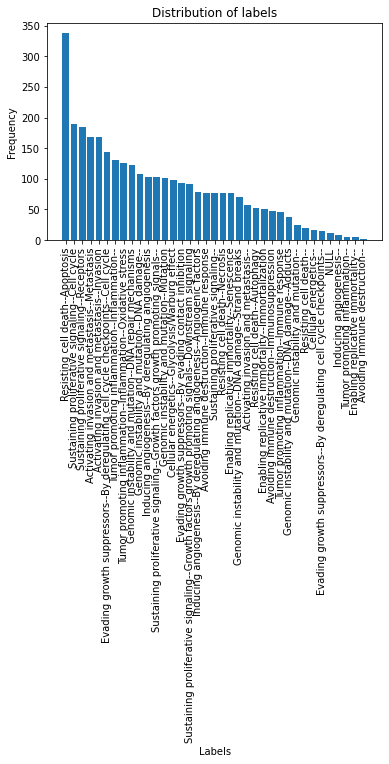

In [9]:
plt.bar(x=frequencies.keys(), height=frequencies.values())
plt.title("Distribution of labels")
plt.xlabel("Labels")
plt.xticks(range(len(frequencies)), frequencies.keys(), rotation='vertical')
plt.ylabel("Frequency")
plt.show()

# Corpus Statistics

100%|██████████| 1852/1852 [00:00<00:00, 34443.72it/s]


 average words per text: 243.74352051835854
 standard deviation on words per text: 68.97321283430158
 average sentences per text: 9.429805615550755


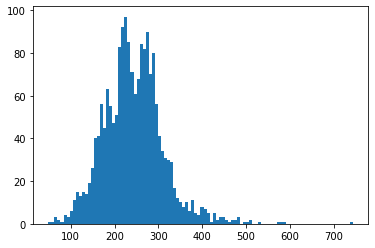

In [10]:
text_words = []
for row in tqdm.tqdm(dataset):
    text = row['text']
    text_words.append(len(text.split()))
    
mean_text_words = np.mean(text_words)
sd_text_words = np.std(text_words)
mean_text_sentences = number_of_sentences / len(dataset)
print(' average words per text:', mean_text_words)
print(' standard deviation on words per text:', sd_text_words)
print(' average sentences per text:', mean_text_sentences)
    
plt.hist(text_words, bins = 100)
plt.show()

# Save dataset in json format

In [ ]:
from sklearn.model_selection import train_test_split

In [18]:
train, val = train_test_split(dataset, test_size=0.15, random_state=44)

In [20]:
len(val)

278

In [21]:
len(train)

1574

In [24]:
with open("train.json", "w") as ftrain:
    json.dump(train, ftrain)
with open("val.json", "w") as fval:
    json.dump(val, fval)